## 크롤러 만들기

In [7]:
# 크롤러를 만들기 전 필요한 도구들을 임포트합니다.
import requests
import pandas as pd
from bs4 import BeautifulSoup

# 페이지 수, 카테고리, 날짜를 입력값으로 받습니다.
def make_urllist(page_num, code, date): 
  urllist= []
  for i in range(1, page_num + 1):
    url = 'https://news.naver.com/main/list.nhn?mode=LSD&mid=sec&sid1='+str(code)+'&date='+str(date)+'&page='+str(i)   
    news = requests.get(url)

    # BeautifulSoup의 인스턴스 생성합니다. 파서는 html.parser를 사용합니다.
    soup = BeautifulSoup(news.content, 'html.parser')

    # CASE 1
    news_list = soup.select('.newsflash_body .type06_headline li dl')
    # CASE 2
    news_list.extend(soup.select('.newsflash_body .type06 li dl'))
        
    # 각 뉴스로부터 a 태그인 <a href ='주소'> 에서 '주소'만을 가져옵니다.
    for line in news_list:
        urllist.append(line.a.get('href'))
  return urllist

In [25]:
url_list = make_urllist(2, 101, 20200804)
print('뉴스 기사의 개수: ',len(url_list))

뉴스 기사의 개수:  40


In [9]:
idx2word = {'101' : '경제', '102' : '사회', '103' : '생활/문화', '105' : 'IT/과학'}

In [10]:
from newspaper import Article

#- 데이터프레임을 생성하는 함수입니다.
def make_data(urllist, code):
  text_list = []
  for url in urllist:
    article = Article(url, language='ko')
    article.download()
    article.parse()
    text_list.append(article.text)

  #- 데이터프레임의 'news' 키 아래 파싱한 텍스트를 밸류로 붙여줍니다.
  df = pd.DataFrame({'news': text_list})

  #- 데이터프레임의 'code' 키 아래 한글 카테고리명을 붙여줍니다.
  df['code'] = idx2word[str(code)]
  return df

In [11]:
data = make_data(url_list, 101)
#- 상위 10개만 출력해봅니다.
data[:10]

,news,code
0,고려은단이 5월을 맞아 응원 메시지를 공유하는 ‘5월 5글자로 응원 부탁해!’ 이벤...,경제
1,코리아나화장품의 민감성 피부를 위한 저자극 스킨케어 브랜드 '프리엔제'가 마르고 건...,경제
2,서울장수주식회사가 부드럽고 달콤한 맛으로 인기를 모으고 있는 생막걸리 ‘인생막걸리’...,경제
3,[서울=뉴시스] 오동현 기자 = 모바일 게임 기업 컴투스는 3D 모바일 야구 게임 ...,경제
4,대원제약이 2020년 상반기 신입과 경력 정기 공채를 실시합니다.정기 공채 모집분야...,경제
5,"[AFP=연합뉴스] [AFP=연합뉴스]\n\n""요즘은 잔인한 날""…리프트도 앞서 9...",경제
6,이재용 삼성전자 부회장이 6일 삼성전자 서울 서초사옥에서 대국민 사과 회견을 하기 ...,경제
7,JW중외제약이 A형 혈우병 예방요법제 ‘헴리브라피하주사를 출시하고 본격적인 마케팅 ...,경제
8,"옵티팜과 휴벳바이오가 공동 개발중인 백신 후보 물질에 대해 마우스, 기니피그, 미니...",경제
9,[한국경제TV 신동호 기자]\n\n전남 나주시와 충북 청주시가 방사광 가속기 구축사...,경제


## 데이터 수집 및 전처리

### 데이터 수집

In [13]:
code_list = [102, 103, 105]

code_list

[102, 103, 105]

In [14]:
def make_total_data(page_num, code_list, date):
  df = None

  for code in code_list:
    url_list = make_urllist(page_num, code, date)
    df_temp = make_data(url_list, code)
    print(str(code)+'번 코드에 대한 데이터를 만들었습니다.')

    if df is not None:
      df = pd.concat([df, df_temp])
    else:
      df = df_temp

  return df

In [15]:
df = make_total_data(1, code_list, 20200506)

102번 코드에 대한 데이터를 만들었습니다.
103번 코드에 대한 데이터를 만들었습니다.
105번 코드에 대한 데이터를 만들었습니다.


In [16]:
# 랜덤 샘플 출력

df.sample(10)

,news,code
19,동영상 뉴스\n\n[앵커]생활 속 거리두기가 시작되면서 박물관과 미술관 등 문화예술...,생활/문화
3,©아가타 파리(AGATHA PARIS) ©아가타 파리(AGATHA PARIS)\n\...,생활/문화
16,6일 국회에서 열린 과방위 법안소위 6일 국회에서 열린 과방위 법안소위\n\n[아이...,IT/과학
1,동영상 뉴스\n\n오늘 서쪽 지방과 동쪽 지방의 온도 차가 제법 컸습니다.서쪽 지방...,생활/문화
14,동영상 뉴스\n\n[앵커]코로나19 신규 확진자가 2명 발생해 78일 만에 최저치를...,사회
11,▲포항가속기연구소에 설치돼 있는 4세대 방사광가속기. 1.1km의 직선으로 이뤄져 ...,IT/과학
7,[한국경제TV 김주리 기자]\n\n지구에서 약 1천광년밖에 떨어지지 않은 곳에서 맨...,IT/과학
6,“코로나19에 걸렸다 나은 친구는 아무래도 좀 멀리하게 될 것 같아요. 재발 가능성...,사회
19,이남식 서울예대 총장(왼쪽) 안심키트 배포. 사진제공=서울예대 이남식 서울예대 총장...,사회
6,[서울=뉴시스] 오동현 기자 = 펍지주식회사가 올해 첫 '플레이어언노운스 배틀그라운...,IT/과학


In [17]:
## 대량 크롤링 

#df = make_total_data(100, code_list, 20200506)

## 데이터 저장

import os

# 데이터프레임 파일을 csv 파일로 저장합니다.
# 저장경로는 이번 프로젝트를 위해 만든 폴더로 지정해 주세요.
csv_path = os.getenv("HOME") + "/workplace/aiffel/Explore/03. news_crawler/news_data.csv3"
df.to_csv(csv_path, index=False)

if os.path.exists(csv_path):
  print('{} File Saved!'.format(csv_path))

/home/aiffel0047/workplace/aiffel/Explore/03. news_crawler/news_data.csv3 File Saved!


## 데이터 전처리

### 데이터 정제

In [19]:
csv_path = os.getenv("HOME") + "/workplace/aiffel/Explore/03. news_crawler/news_data.csv3"
df = pd.read_table(csv_path, sep=',')
df.head()

,news,code
0,파주시청. 사진제공=파주시 파주시청. 사진제공=파주시\n\n[파주=파이낸셜뉴스 강근...,사회
1,동영상 뉴스\n\n이천 물류창고 화재 발화지점으로 지목된 지하 2층에서 산소절단기의...,사회
2,황범순 의정부시 부시장 을지대학교 의정부캠퍼스 및 부속병원 공사현장 안전점검. 사진...,사회
3,귀갓길 여성을 쫓아가 성범죄를 시도한 20대 남성이 구속됐습니다.서울 강남경찰서는 ...,사회
4,(서울=연합뉴스) 대한약사회가 6일부터 코로나바이러스 감염증 대응 체계를 '사회적 ...,사회


In [21]:
# 정규 표현식을 이용해서 한글 외의 문자는 전부 제거합니다.
df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df['news']

0     파주시청 사진제공파주시 파주시청 사진제공파주시파주파이낸셜뉴스 강근주 기자 파주시는 ...
1     동영상 뉴스이천 물류창고 화재 발화지점으로 지목된 지하 층에서 산소절단기의 산소 공...
2     황범순 의정부시 부시장 을지대학교 의정부캠퍼스 및 부속병원 공사현장 안전점검 사진제...
3     귀갓길 여성을 쫓아가 성범죄를 시도한 대 남성이 구속됐습니다서울 강남경찰서는 강간상...
4     서울연합뉴스 대한약사회가 일부터 코로나바이러스 감염증 대응 체계를 사회적 거리두기에...
5     질서정연 코로나 확산 방지를 위한 물리적 거리 두기가 생활 속 거리 두기로 전환된 ...
6     코로나에 걸렸다 나은 친구는 아무래도 좀 멀리하게 될 것 같아요 재발 가능성 때문에...
7     년 메이저리그  다저스의 시즌 마지막 경기였다 신인 타자 더스티 베이커현 휴스턴 애...
8     일 등교수업을 앞둔 경북 한 학교의 보건실에는 손소독제 마스크 등 방역물품이 상자째...
9     경찰 로고뉴스   신채린 기자 경찰 로고뉴스   신채린 기자서울뉴스 이상학 기자  ...
10    안병용 의정부시장 이천화재 희생자 합동분향소 헌화 사진제공의정부시 안병용 의정부시장...
11    이재용 삼성전자 부회장의 일 대국민 사과가 그를 상대로 한 수사재판에 어떤 영향을 ...
12    동영상 뉴스앵커다음 주 고등학교 학년부터 순차적인 등교수업이 시작되는데 교실 방역에...
13    명의 사망자가 발생한 경기 이천 물류창고 화재 현장에서 일 경찰과 소방 등 관계기관...
14    동영상 뉴스앵커코로나 신규 확진자가 명 발생해 일 만에 최저치를 기록했습니다방역 당...
15    뉴스  뉴스 서울뉴스 이상학 기자  밤에 귀가하던 여성에게 성범죄를 시도한 대 남성...
16    메건 마클 왕자비와 아들 아치의 모습세이브더칠드런 인스타그램 캡처 재판매 및  금지...
17    국내 최초로 건립되는 노동문학관이 일 첫 삽을 떴다노동문학관건립위원회위원장 

In [22]:
print(df.isnull().sum())

news    0
code    0
dtype: int64


In [18]:
# 중복된 샘플들을 제거합니다.
df.drop_duplicates(subset=['news'], inplace=True)

print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  53


### 데이터 탐색

/home/aiffel0047/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel0047/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54924 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel0047/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44284 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel0047/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54617 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel0047/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home

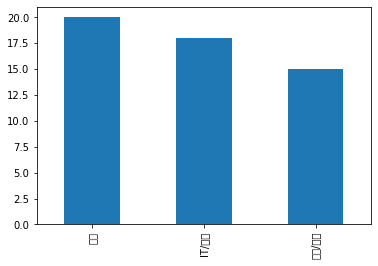

In [19]:
df['code'].value_counts().plot(kind = 'bar')

In [20]:
print(df.groupby('code').size().reset_index(name = 'count'))

    code  count
0  IT/과학     18
1     사회     20
2  생활/문화     15


### 토큰화

In [21]:
from konlpy.tag import Mecab
tokenizer = Mecab()

kor_text = '밤에 귀가하던 여성에게 범죄를 시도한 대 남성이 구속됐다서울 제주경찰서는 \
            상해 혐의로 씨를 구속해 수사하고 있다고 일 밝혔다씨는 지난달 일 피해 여성을 \
            인근 지하철 역에서부터 따라가 폭행을 시도하려다가 도망간 혐의를 받는다피해 \
            여성이 저항하자 놀란 씨는 도망갔으며 신고를 받고 주변을 수색하던 경찰에 \
            체포됐다피해 여성은 이 과정에서 경미한 부상을 입은 것으로 전해졌다'

#- 형태소 분석, 즉 토큰화(tokenization)를 합니다.
print(tokenizer.morphs(kor_text))

['밤', '에', '귀가', '하', '던', '여성', '에게', '범죄', '를', '시도', '한', '대', '남성', '이', '구속', '됐', '다', '서울', '제주', '경찰서', '는', '상해', '혐의', '로', '씨', '를', '구속', '해', '수사', '하', '고', '있', '다고', '일', '밝혔', '다', '씨', '는', '지난달', '일', '피해', '여성', '을', '인근', '지하철', '역', '에서부터', '따라가', '폭행', '을', '시도', '하', '려다가', '도망간', '혐의', '를', '받', '는다', '피해', '여성', '이', '저항', '하', '자', '놀란', '씨', '는', '도망갔으며', '신고', '를', '받', '고', '주변', '을', '수색', '하', '던', '경찰', '에', '체포', '됐', '다', '피해', '여성', '은', '이', '과정', '에서', '경미', '한', '부상', '을', '입', '은', '것', '으로', '전해졌', '다']


### 불용어 제거
- 조사

In [22]:
stopwords = ['에','는','은','을','했','에게','있','이','의','하','한','다','과','때문','할','수','무단','따른','및','금지','전재','경향신문','기자','는데','가','등','들','파이낸셜','저작','등','뉴스']

In [23]:
# 토큰화 및 토큰화 과정에서 불용어를 제거하는 함수입니다.
def preprocessing(data):
  text_data = []

  for sentence in data:
    temp_data = []
    #- 토큰화
    temp_data = tokenizer.morphs(sentence) 
    #- 불용어 제거
    temp_data = [word for word in temp_data if not word in stopwords] 
    text_data.append(temp_data)

  text_data = list(map(' '.join, text_data))

  return text_data

In [24]:
text_data = preprocessing(df['news'])
print(text_data[0])

파주 시청 . 사진 제공 = 파주시 파주 시청 . 사진 제공 = 파주시 [ 파주 = 강근주 ] 파주시 4 일 관내 취약 계층 1 만 9379 가구 대해 정부 긴급 재난 지원금 입금 완료 . 파주 시민 받 긴급 재난 지원금 ‘ 4 인 이상 가구 ’ 기준 으로 87 만 1000 원 받 게 되 며 , 3 인 가구 69 만 7000 원 , 2 인 가구 52 만 3000 원 , 1 인 가구 34 만 8000 원 . 정부 발표 긴급 재난 지원금 파주 시민 지급 금액 다른 이유 국비 - 지방비 부담 비율 . 파주시 이미 모든 시민 ‘ 경기도 - 파주시 재난 기본소득 ’( 1 인 당 각 10 만 원 ) 지급 고 어 시민 국비 지원금 만 지급 며 4 인 가구 기준 으로 총 지원 금액 ‘ 파주시 재난 기본소득 ’ 40 만 원 , ‘ 경기도 재난 기본소득 ’ 40 만 원 , ‘ 정부 긴급 재난 지원금 ’ 87 만 1000 원 총 167 만 1000 원 받 게 된다 . 취약 계층 아닌 시민 오 5 월 11 일 부터 소지 고 신용 · 체크카드 사 홈페이지 에서 긴급 재난 지원금 지원 신청 . 세대주 가족 지원금 일괄 신청 해야 한다 . 편 파 주 시 3 일 김정기 부시장 단장 으로 ‘ 긴급 재난 지원금 추진 태 스 크 포스 ’ 를 구성 해 긴급 재난 지원금 원활 게 지급 될 도록 지원 한다 . ※ 저작권자 ⓒ . - 재 배포
